In [1]:
import numpy as np
from numpy.random import default_rng
from pydeep.rbm.model import GaussianBinaryRBM
import os
import os.path as op
import pandas as pd
from prob_models.utils.utils import read_paths, getdata
from pydeep.rbm.trainer import CD
from pydeep.rbm.estimator import (partition_function_factorize_h, 
                                  log_likelihood_v, 
                                  reconstruction_error,
                                  annealed_importance_sampling)

In [ ]:
def split_train_test(X, train_fraction, standardize=False, shuffle=True, seed=None):
    rng = default_rng(seed)
    X = X.copy()
    if shuffle:
        rng.shuffle(X)
    T, N = X.shape
    Xtrain = X[:int(train_fraction*T)]
    Xtest = X[int(train_fraction*T):]
    if standardize:
        avg = np.mean(Xtrain, axis=0)
        Xtrain -= avg 
        std = np.std(Xtrain, axis=0)
        Xtrain /= std
        
        Xtest -= avg
        Xtest /= std


    return Xtrain, Xtest


def train_rbm(X_train, X_test, n_hid, epochs):
    n_v = X_train.shape[-1]
    variances = np.var(X_train, axis=0, keepdims=True)
    
    results = {}
    epoch_module = 20
    ll_trains = np.zeros((len(n_hid), int(epochs/epoch_module)+1))
    ll_tests = np.zeros((len(n_hid), int(epochs/epoch_module)+1))
    count = 0
    

    for n_h in n_hid:
        print(f'\nTraining with {n_h} hidden units')
        count += 1
        
        grbm = GaussianBinaryRBM(number_visibles=n_v,
                                number_hiddens=n_h,
                                data=X1_train,initial_sigma=variances,
                                initial_visible_offsets=0.0,
                                initial_hidden_offsets=0.0)
        trainer = CD(grbm)
        
        count_epoch = 0
        for epoch in range(epochs):
               
            trainer.train(data = X_train)
            
            if epoch % epoch_module == 0:
                count_epoch += 1 
                print(f'Epoch {epoch}')
                log_z = annealed_importance_sampling(grbm, status=False)
                ll_trains[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_train))
                ll_tests[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_test))
                print('ll_train is', ll_trains[count-1, count_epoch-1])
                print('ll_test is', ll_tests[count-1, count_epoch-1])
        
        ll_trains = np.array(ll_trains)
        ll_tests = np.array(ll_tests)
        print('Computing log-likelihood and reconstruction error...')
        # log_z = partition_function_factorize_h(grbm, status=False)
        log_z = annealed_importance_sampling(grbm, status=False)
        ll_train = np.mean(log_likelihood_v(grbm, log_z, X_train))
        ll_test = np.mean(log_likelihood_v(grbm, log_z, X_test))
        re = np.mean(reconstruction_error(grbm, X_train))
        print('...done')
        
        results[n_h] = {'ll_train': ll_train, 'll_test': ll_test, 're': re}
        
    results = pd.DataFrame.from_dict(results, orient='index')
    return results, ll_trains, ll_tests

In [ ]:
# Load data 
paths = read_paths(op.join(os.getcwd(), op.join('..', '..', 'paths.txt')))
datadic = getdata(paths, dataset='CamCAN')
T, N = np.shape(list(datadic.values())[0])

tf = 0.8
X1 = datadic[1]

X1_train, X1_test = split_train_test(X1, train_fraction=tf, standardize=True, seed=0)
print(f'X1 shape: {X1_train.shape}')

n_hid = np.arange(2, 10, 3)
epochs = 100
results, ll_trains, ll_tests = train_rbm(X1_train, X1_test, n_hid, epochs)
print(results)


X1 shape: (208, 114)

Training with 2 hidden units
Epoch 0
ll_train is -162.7116537883756
ll_test is -182.17212933583536
Epoch 5
ll_train is -162.49374946397901
ll_test is -181.9050782664742
Epoch 10
ll_train is -162.2090871726
ll_test is -181.5443566369948
Epoch 15
ll_train is -161.85478162560224
ll_test is -181.0870280058585
Epoch 20
ll_train is -161.43113481732465
ll_test is -180.54293500166622
Computing log-likelihood and reconstruction error...
...done

Training with 5 hidden units
Epoch 0
ll_train is -164.1941357800096
ll_test is -183.72699610260963
Epoch 5
ll_train is -163.09163085777558
ll_test is -182.43861535280746
Epoch 10
ll_train is -161.88918783240783
ll_test is -180.95657509763384
Epoch 15
ll_train is -160.50543687868665
ll_test is -179.20472310439902
Epoch 20
ll_train is -158.96236113072067
ll_test is -177.23354176383046
Computing log-likelihood and reconstruction error...
...done

Training with 8 hidden units
Epoch 0
ll_train is -164.76153904694837
ll_test is -184.1927

In [11]:
import matplotlib.pyplot as plt

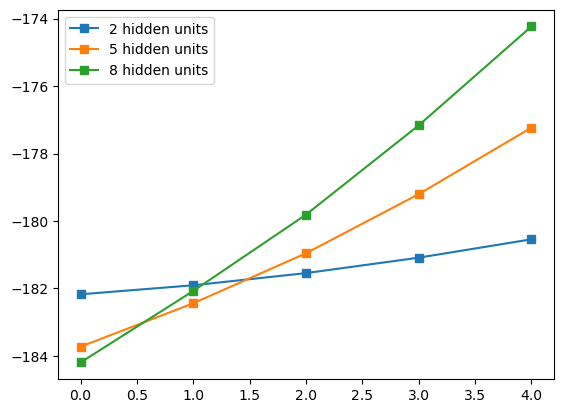

In [28]:
for el, h in zip(ll_tests, n_hid):
    plt.plot(el,'s-', label=f'{h} hidden units')
plt.legend()
plt.show()

In [15]:
np.shape(ll_tests)

(5, 22)